In [1]:
import sys
sys.path.append('../../')
import torch

from fourier_scaffold import (
    FourierScaffold,
    FourierScaffoldDebug,
    HammardSharpening,
    ContractionSharpening,
    GaussianFourierSmoothing,
    GuassianFourierSmoothingMatrix,
    HammardShiftMatrix,
    calculate_padding,
)
import math
import matplotlib.pyplot as plt

device = "cuda"
shapes = torch.tensor([(5, 5), (7, 7)], device=device)
nruns=5
dim_sizes = [int(shapes[:, dim].prod().item()) for dim in range(shapes.shape[1])]


def zero():
    return torch.zeros(*dim_sizes, device=device)


def uniform():
    t = torch.ones_like(zero())
    return t / t.sum()


def degenerate():
    t = zero()
    t[tuple([0] * shapes.shape[1])] = 1
    return t


def gaussian(sigma=1):
    t = degenerate()
    kernel_size = 2 * max(10, 3 * math.ceil(sigma)) + 1
    x = torch.arange(kernel_size, device=device) - kernel_size // 2
    y = torch.arange(kernel_size, device=device) - kernel_size // 2
    x, y = torch.meshgrid(x, y)
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()

    x_padding = calculate_padding(kernel_size, kernel.shape[0], 1)
    y_padding = calculate_padding(kernel_size, kernel.shape[1], 1)

    padded = torch.nn.functional.pad(
        t.unsqueeze(0).unsqueeze(0),
        y_padding + x_padding,
        mode="circular",
    )

    convoluted = torch.nn.functional.conv2d(
        input=padded, weight=kernel.unsqueeze(0).unsqueeze(0)
    )

    return convoluted.squeeze(0).squeeze(0)


def bimodal():
    t = zero()
    index = [0] * shapes.shape[1]
    for i, size in enumerate(dim_sizes):
        index[i] = size // 2

    t[tuple([0] * shapes.shape[1])] = 0.5
    t[tuple(index)] = 0.5
    return t

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../vectorhash_functions.py:1: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.special


In [2]:
distributions = [
    ("degenerate", degenerate()),
    ("uniform", uniform()),
    ("gaussian σ=0.5", gaussian(0.5)),
    ("gaussian σ=1", gaussian(1)),
    ("gaussian σ=2", gaussian(2)),
    ("bimodal", bimodal()),
]

scaffold_debug = FourierScaffoldDebug(shapes, device=device)


def l2_err(v1: torch.Tensor, v2: torch.Tensor):
    return torch.linalg.vector_norm(v1 - v2)


def run_test(
    distribution: torch.Tensor,
    scaffold: FourierScaffold,
    scaffold_debug: FourierScaffoldDebug,
):
    scaffold.g = scaffold.encode_probability(distribution)
    scaffold_debug.ptensor = distribution

    # print(scaffold.g)
    # print(scaffold_debug.ptensor)

    estimated = scaffold.get_all_probabilities().flatten()
    true = scaffold_debug.ptensor.flatten()
    encoding_similarity = torch.cosine_similarity(true, estimated, dim=0)
    encoding_l2 = l2_err(true, estimated)
    print("encoding l2:", encoding_l2)

    scaffold.sharpen()
    scaffold_debug.sharpen()

    # print(scaffold.g)
    # print(scaffold_debug.ptensor)

    estimated = scaffold.get_all_probabilities().flatten()
    true = scaffold_debug.ptensor.flatten()
    sharpening_similarity = torch.cosine_similarity(true, estimated, dim=0)
    sharpened_l2 = l2_err(true, estimated)
    print("sharpened l2:", sharpened_l2)
    return encoding_similarity, sharpening_similarity, encoding_l2, sharpened_l2

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../fourier_scaffold.py:432: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


In [3]:
# (Ds (3), methods (2))
Ds = [10, 31, 100, 310, 1000]
rescaling = False

encoding_similarities = torch.zeros(len(distributions), len(Ds), 2, nruns)
sharpened_similarities = torch.zeros(len(distributions), len(Ds), 2, nruns)

encoding_l2s = torch.zeros(len(distributions), len(Ds), 2, nruns)
sharpened_l2s = torch.zeros(len(distributions), len(Ds), 2, nruns)


for i, [name, distribution] in enumerate(distributions):
    for j, D in enumerate(Ds):
        for run in range(nruns):
            print(
                f" ----------------------- running test: {name} ({i}/{len(distributions)}), D={D} ({j}/{len(Ds)}), run {run}/{nruns} --------------------"
            )
            scaffold_v = FourierScaffold(
                shapes,
                D=D**2,
                sharpening=HammardSharpening(2),
                smoothing=GaussianFourierSmoothing(
                    kernel_radii=[10, 10], kernel_sigmas=[1, 1]
                ),  # doesnt matter just so it runs
                device=device,
                rescaling=rescaling
            )
            scaffold_m = FourierScaffold(
                shapes,
                D=D,
                sharpening=ContractionSharpening(2),
                shift=HammardShiftMatrix(),
                smoothing=GuassianFourierSmoothingMatrix(
                    kernel_radii=[10, 10], kernel_sigmas=[1, 1]
                ),  # doesnt matter just so it runs
                device=device,
                representation="matrix",
                rescaling=rescaling
            )
            scaffold_debug = FourierScaffoldDebug(shapes, device=device)

            (
                encoding_similarity_v,
                sharpened_similarity_v,
                encoding_l2_v,
                sharpened_l2_v,
            ) = run_test(distribution.clone(), scaffold_v, scaffold_debug)
            (
                encoding_similarity_m,
                sharpened_similarity_m,
                encoding_l2_m,
                sharpened_l2_m,
            ) = run_test(distribution.clone(), scaffold_m, scaffold_debug)

            encoding_similarities[i, j, 0, run] = encoding_similarity_v
            encoding_similarities[i, j, 1, run] = encoding_similarity_m
            sharpened_similarities[i, j, 0, run] = sharpened_similarity_v
            sharpened_similarities[i, j, 1, run] = sharpened_similarity_m

            encoding_l2s[i, j, 0, run] = encoding_l2_v
            encoding_l2s[i, j, 1, run] = encoding_l2_m
            sharpened_l2s[i, j, 0, run] = sharpened_l2_v
            sharpened_l2s[i, j, 1, run] = sharpened_l2_m

 ----------------------- running test: degenerate (0/6), D=10 (0/5), run 0/5 --------------------


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../fourier_scaffold.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  100
M       :  2
d       :  2
N_patts :  1225


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../vectorhash_functions.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(w).to(device).clip(1e-8)


module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  10
M       :  2
d       :  2
N_patts :  1225


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../fourier_scaffold.py:432: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../fourier_scaffold.py:393: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  ptensor[tuple(k)] = p


encoding l2: tensor(2.3953, device='cuda:0')
sharpened l2: tensor(2.3953, device='cuda:0')
encoding l2: tensor(4.8224, device='cuda:0')
sharpened l2: tensor(4.8224, device='cuda:0')
 ----------------------- running test: degenerate (0/6), D=10 (0/5), run 1/5 --------------------
module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  100
M       :  2
d       :  2
N_patts :  1225
module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  10
M       :  2
d       :  2
N_patts :  1225
encoding l2: tensor(2.3953, device='cuda:0')
sharpened l2: tensor(2.3953, device='cuda:0')
encoding l2: tensor(4.7196, device='cuda:0')
sharpened l2: tensor(4.7196, device='cuda:0')
 ----------------------- running test: degenerate (0/6), D=10 (0/5), run 2/5 --------------------
module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  100
M       :  2
d       :  2
N_patts :  1225
module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D

In [4]:
import pickle

with open("encoding_similarities_no_sharp.pkl", "wb") as f:
    pickle.dump(encoding_similarities, f)

with open("sharpened_similarities_no_sharp.pkl", "wb") as f:
    pickle.dump(sharpened_similarities, f)

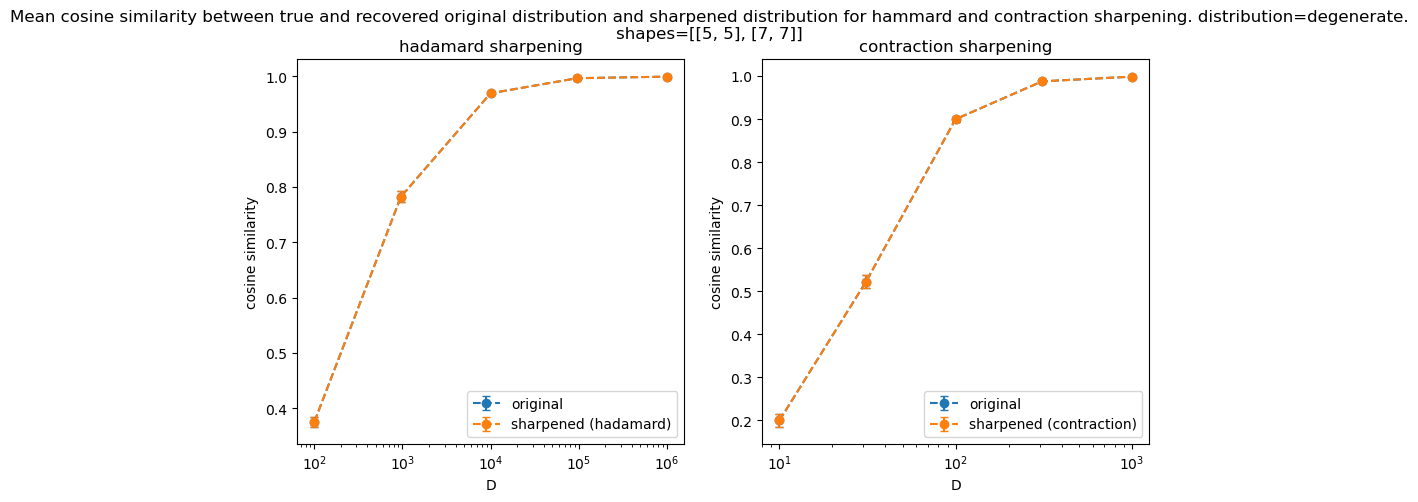

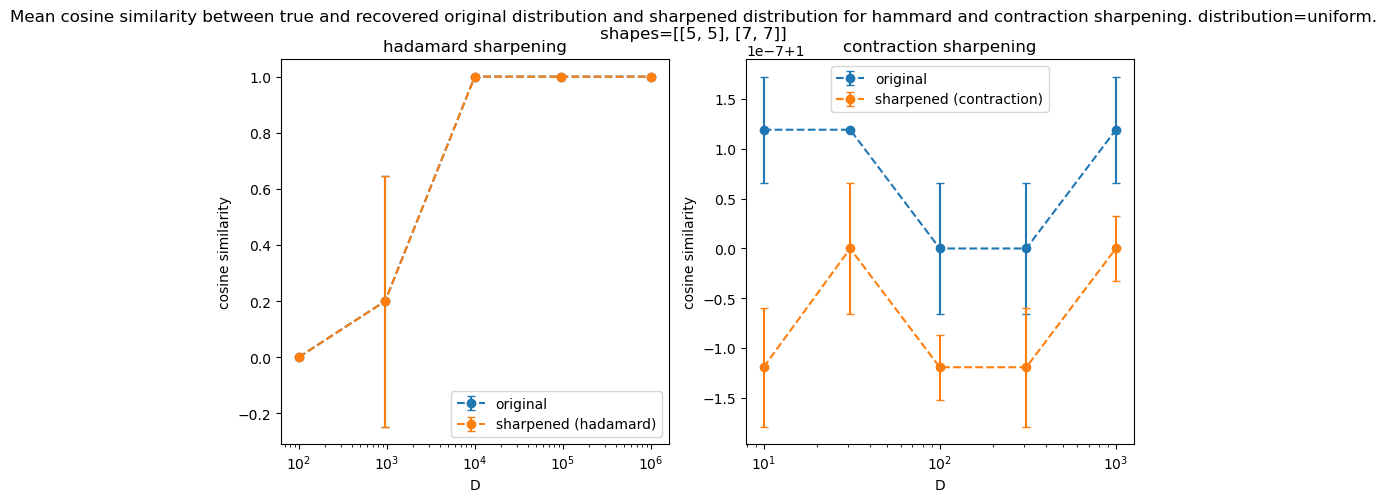

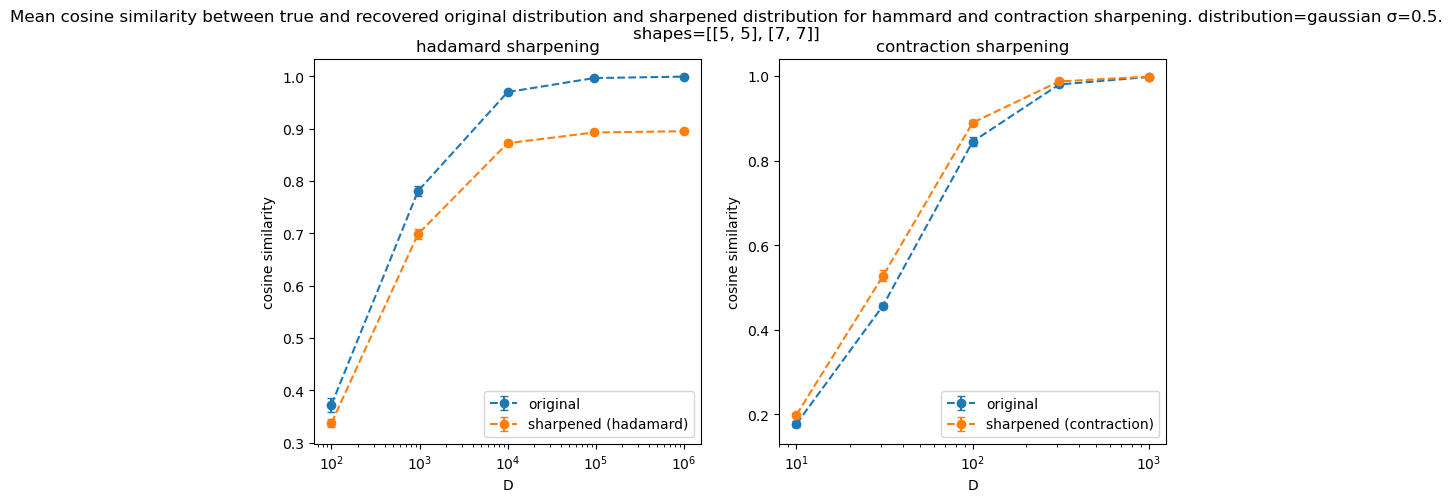

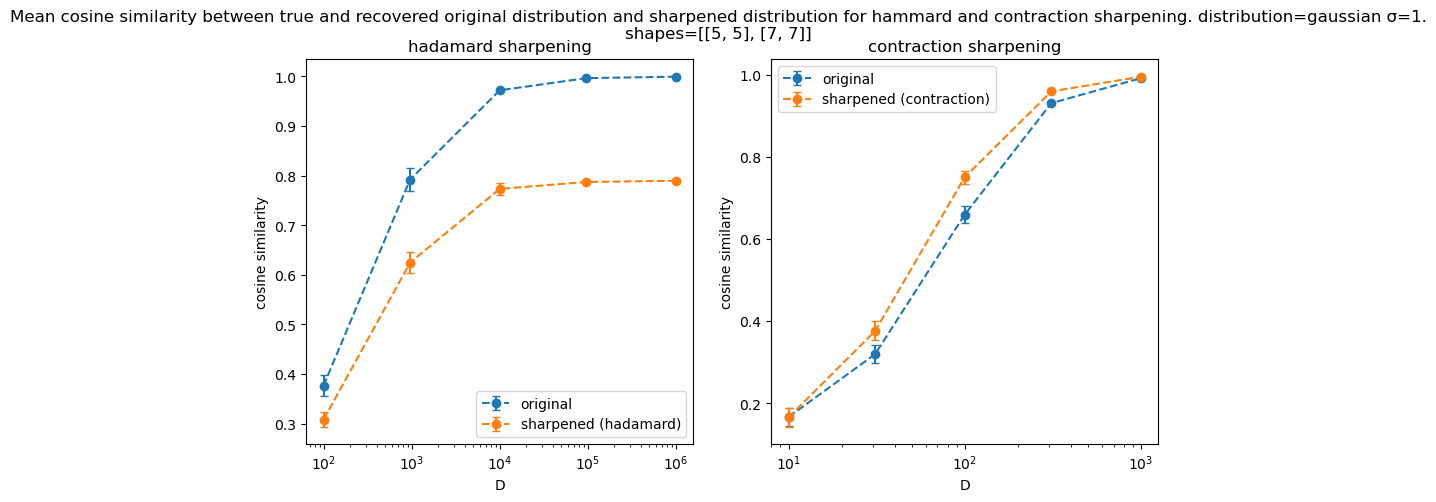

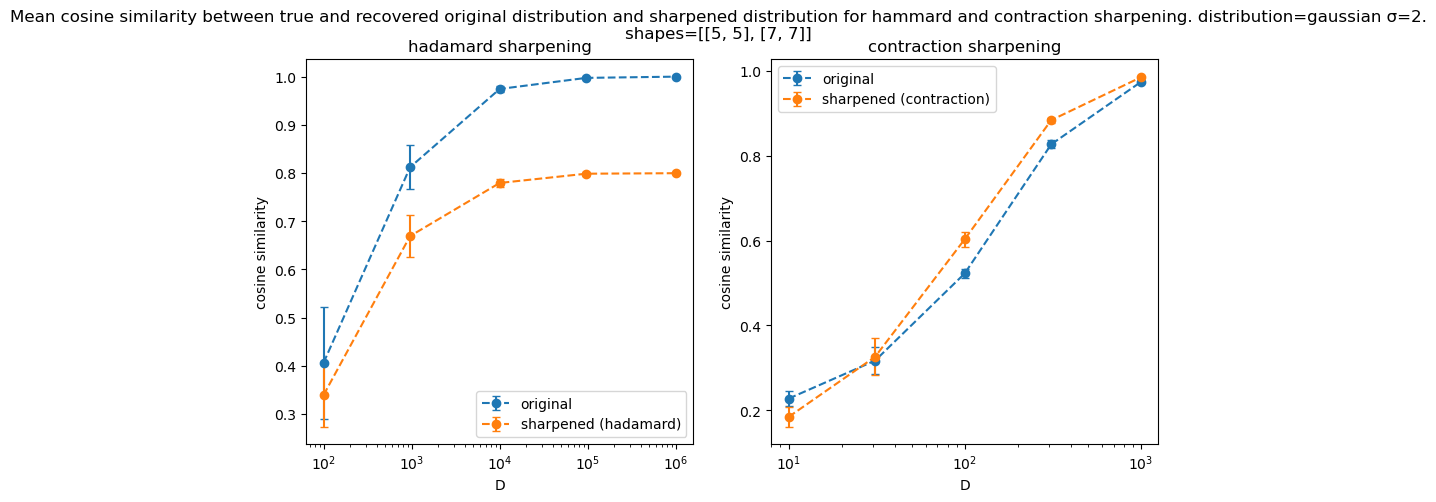

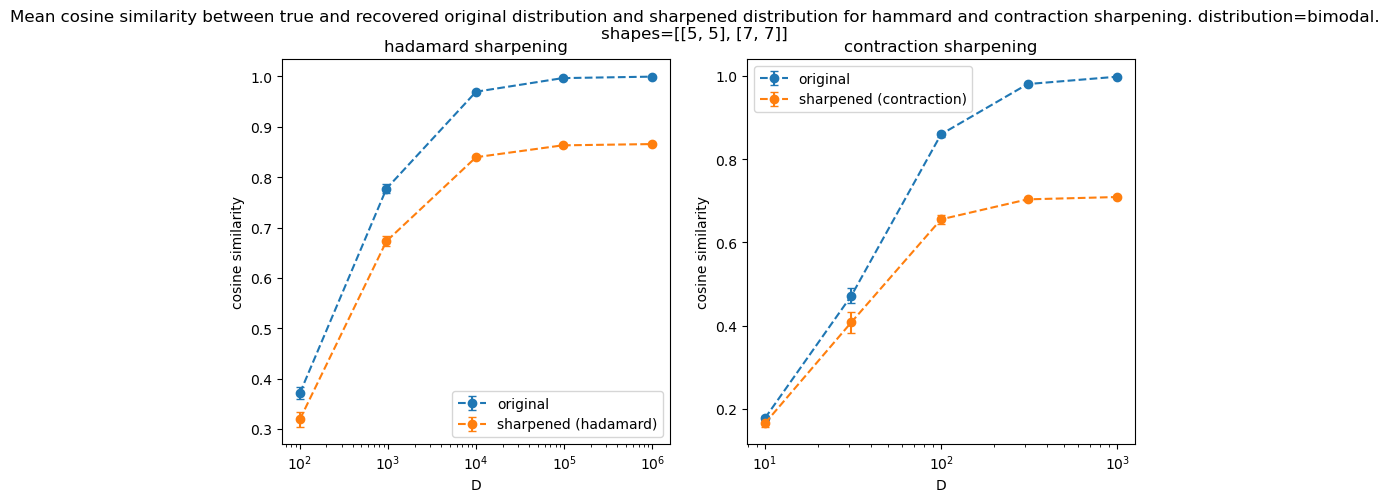

In [ ]:
import matplotlib.pyplot as plt

for i, [name, distribution] in enumerate(distributions):
    fig, ax = plt.subplots(ncols=2, figsize=(11, 5))

    ax[0].errorbar(
        (torch.tensor(Ds)**2).tolist(),
        encoding_similarities[i, :, 0].mean(dim=1),
        yerr=encoding_similarities[i, :, 0].std(dim=1),
        label="original",
        capsize=3,
        fmt="--o",
    )
    ax[0].errorbar(
        (torch.tensor(Ds)**2).tolist(),
        sharpened_similarities[i, :, 0].mean(dim=1),
        yerr=sharpened_similarities[i, :, 0].std(dim=1),
        label="sharpened (hadamard)",
        capsize=3,
        fmt="--o",
    )
    ax[0].set_xscale("log")
    ax[0].legend()
    ax[0].set_ylabel("cosine similarity")
    ax[0].set_xlabel("D")
    # ax[0].set_ylim(-0.2,1)
    ax[0].set_title(f"hadamard sharpening")

    ax[1].errorbar(
        Ds,
        encoding_similarities[i, :, 1].mean(dim=1),
        yerr=encoding_similarities[i, :, 1].std(dim=1),
        label="original",
        capsize=3,
        fmt="--o",
    )
    ax[1].errorbar(
        Ds,
        sharpened_similarities[i, :, 1].mean(dim=1),
        yerr=sharpened_similarities[i, :, 1].std(dim=1),
        label="sharpened (contraction)",
        capsize=3,
        fmt="--o",
    )
    ax[1].set_xscale("log")
    ax[1].legend()
    ax[1].set_ylabel("cosine similarity")
    ax[1].set_xlabel("D")
    # ax[1].set_ylim(-0.2,1)
    ax[1].set_title(f"contraction sharpening")

    fig.suptitle(
        f"Mean cosine similarity between true and recovered original distribution and sharpened distribution for hammard and contraction sharpening. distribution={name}.\nshapes={shapes.cpu().tolist()}"
    )
    if rescaling:
        fig.savefig(f'fourier_scaffold_contraction_testing_cosine_sim_{i}.png')
    else:
        fig.savefig(f'fourier_scaffold_contraction_testing_no_rescaling_cosine_sim_{i}.png')

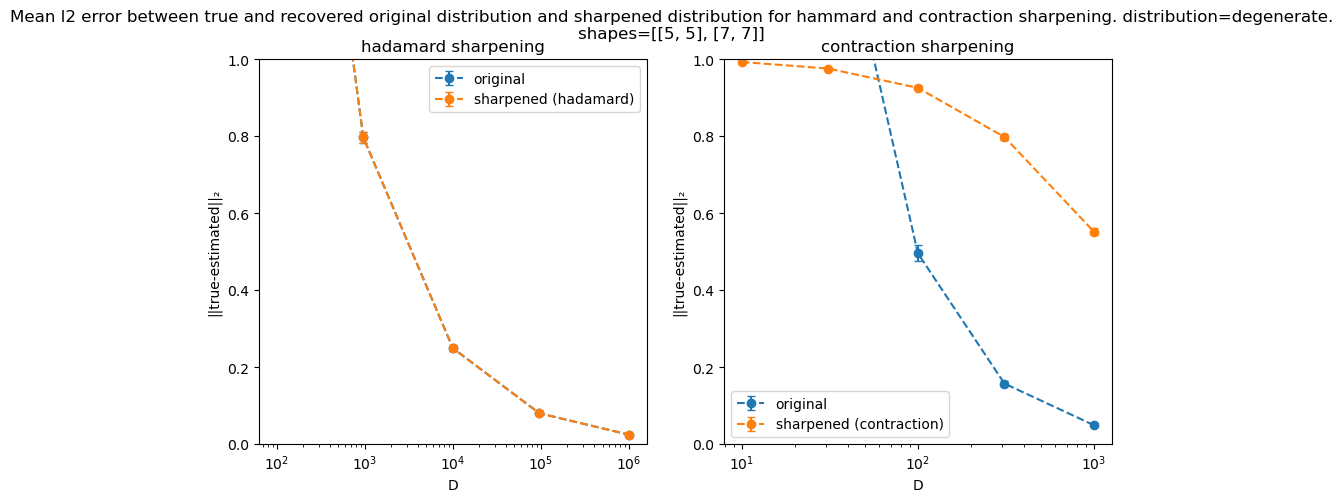

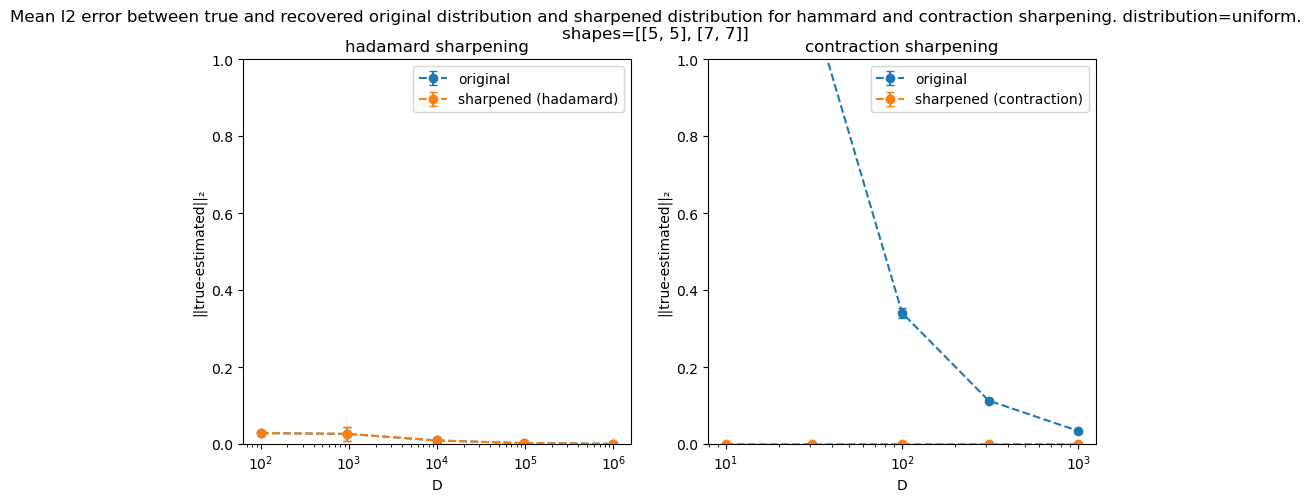

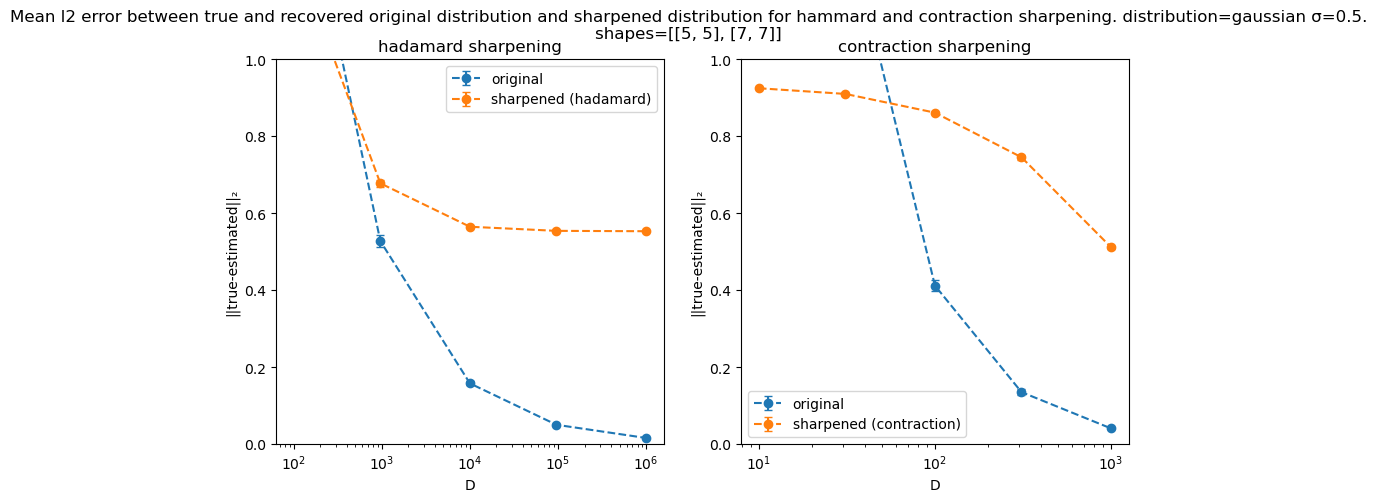

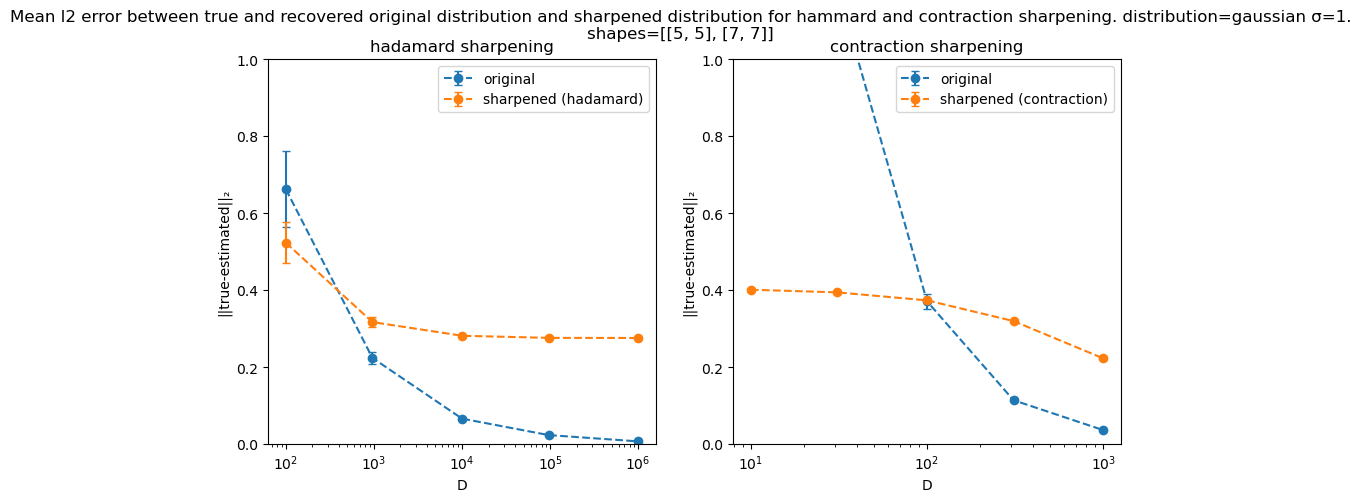

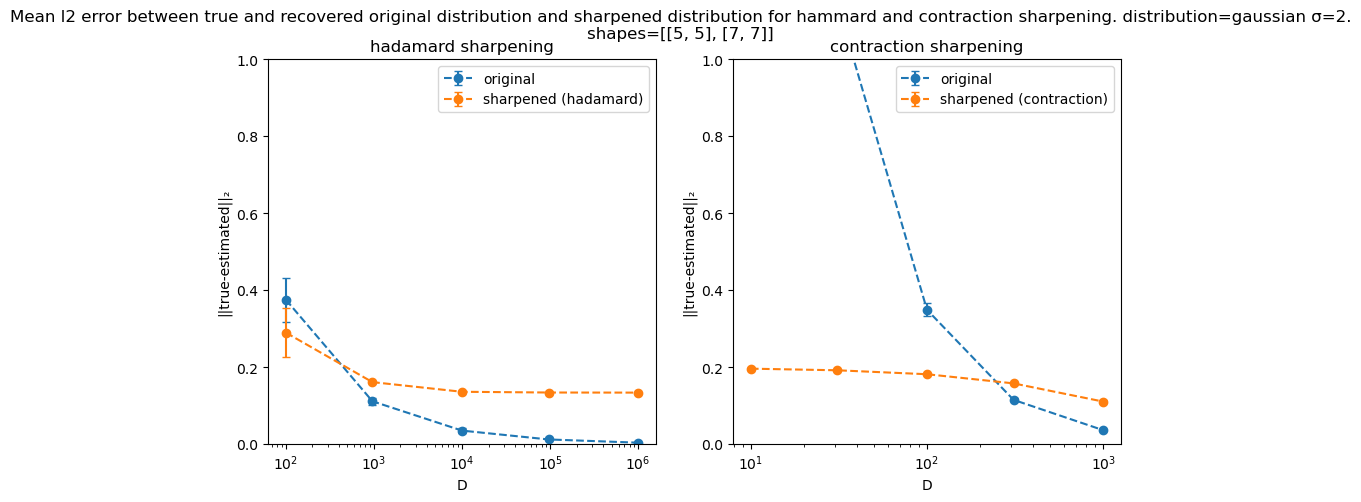

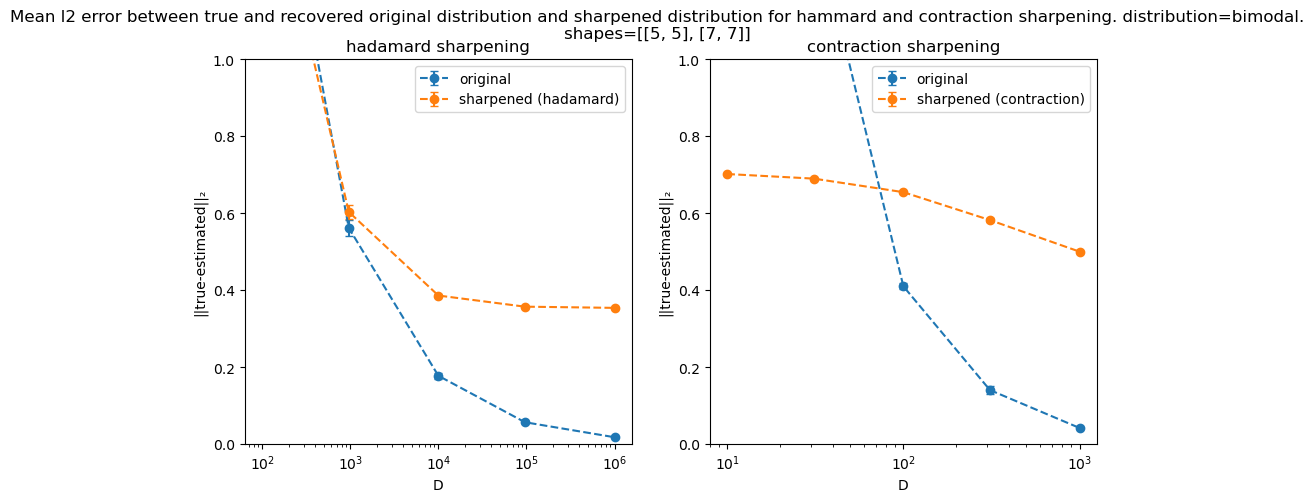

In [ ]:
for i, [name, distribution] in enumerate(distributions):
    fig, ax = plt.subplots(ncols=2, figsize=(11, 5))

    ax[0].errorbar(
        (torch.tensor(Ds) ** 2).tolist(),
        encoding_l2s[i, :, 0].mean(dim=1),
        yerr=encoding_l2s[i, :, 0].std(dim=1),
        label="original",
        capsize=3,
        fmt="--o",
    )
    ax[0].errorbar(
        (torch.tensor(Ds) ** 2).tolist(),
        sharpened_l2s[i, :, 0].mean(dim=1),
        yerr=sharpened_l2s[i, :, 0].std(dim=1),
        label="sharpened (hadamard)",
        capsize=3,
        fmt="--o",
    )
    ax[0].set_xscale("log")
    ax[0].legend()
    ax[0].set_ylabel("||true-estimated||₂")
    ax[0].set_xlabel("D")
    ax[0].set_ylim(0, 1)
    ax[0].set_title(f"hadamard sharpening")

    ax[1].errorbar(
        Ds,
        encoding_l2s[i, :, 1].mean(dim=1),
        yerr=encoding_l2s[i, :, 1].std(dim=1),
        label="original",
        capsize=3,
        fmt="--o",
    )
    ax[1].errorbar(
        Ds,
        sharpened_l2s[i, :, 1].mean(dim=1),
        yerr=sharpened_l2s[i, :, 1].std(dim=1),
        label="sharpened (contraction)",
        capsize=3,
        fmt="--o",
    )
    ax[1].set_xscale("log")
    ax[1].legend()
    ax[1].set_ylabel("||true-estimated||₂")
    ax[1].set_xlabel("D")
    ax[1].set_ylim(0, 1)
    ax[1].set_title(f"contraction sharpening")

    fig.suptitle(
        f"Mean l2 error between true and recovered original distribution and sharpened distribution for hammard and contraction sharpening. distribution={name}.\nshapes={shapes.cpu().tolist()}"
    )
    if rescaling:
        fig.savefig(f"fourier_scaffold_contraction_testing_l2err_{i}.png")
    else:
        fig.savefig(f"fourier_scaffold_contraction_testing_l2err_no_rescaling_{i}.png")

Qualitative results

In [6]:
import torch
import matplotlib.pyplot as plt

from fourier_scaffold import (
    FourierScaffold,
    FourierScaffoldDebug,
    HammardSharpening,
    ContractionSharpening,
    GaussianFourierSmoothing,
    GuassianFourierSmoothingMatrix,
    HammardShiftMatrix,
    calculate_padding,
)

scaffold_debug = FourierScaffoldDebug(shapes, device=device)

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../fourier_scaffold.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shapes = torch.tensor(shapes).int()


module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  1000
M       :  2
d       :  2
N_patts :  1225


/home/ezrahuang/Projects/rl-research/vectorhash/experiments/fourier_scaffold_testing/../../vectorhash_functions.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(w).to(device).clip(1e-8)


module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  1000
M       :  2
d       :  2
N_patts :  1225
tensor(0.7917) tensor(0.7917)
tensor([[ 1.0000e+00,  5.1390e-03,  2.7031e-02,  ..., -1.0424e-02,
          2.7032e-02,  5.1392e-03],
        [-9.9707e-03,  2.4136e-02, -1.5149e-02,  ..., -2.8327e-02,
         -1.3564e-02,  1.6637e-02],
        [ 6.4914e-03, -1.9189e-02,  5.7817e-04,  ...,  4.9348e-03,
          6.4988e-03,  5.6443e-03],
        ...,
        [-1.1738e-02, -1.5877e-02,  2.9114e-03,  ..., -2.0611e-02,
          3.7864e-03, -1.1046e-02],
        [ 6.4914e-03,  5.6444e-03,  6.4986e-03,  ...,  1.0032e-03,
          5.7809e-04, -1.9190e-02],
        [-9.9708e-03,  1.6637e-02, -1.3565e-02,  ...,  3.9830e-02,
         -1.5149e-02,  2.4136e-02]])
tensor([[-5.9605e-08,  5.1390e-03,  2.7031e-02,  ..., -1.0424e-02,
          2.7032e-02,  5.1392e-03],
        [-9.9707e-03,  2.4136e-02, -1.5149e-02,  ..., -2.8327e-02,
         -1.3564e-02,  1.6637e-02],
        

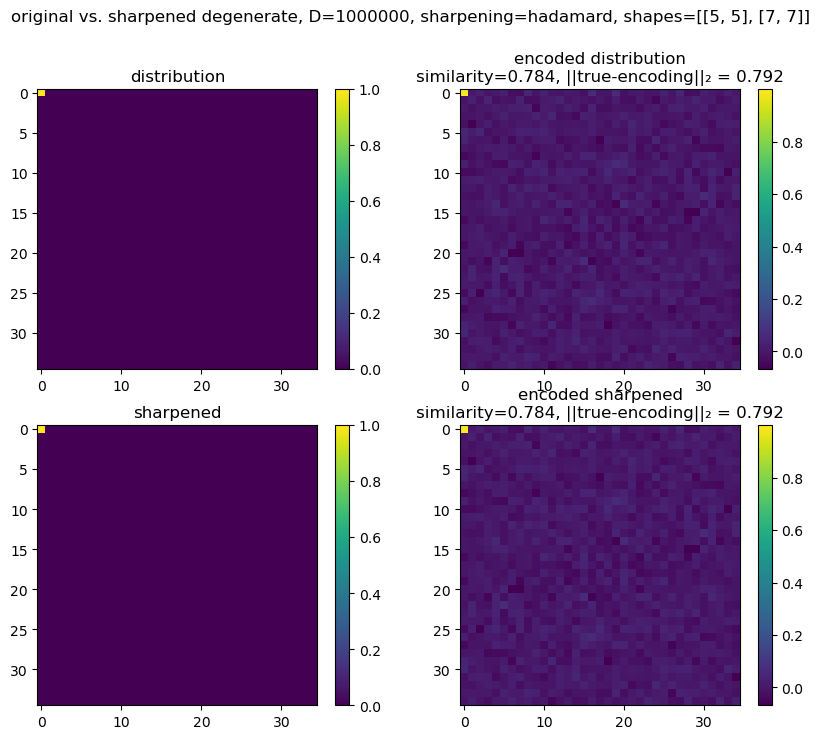

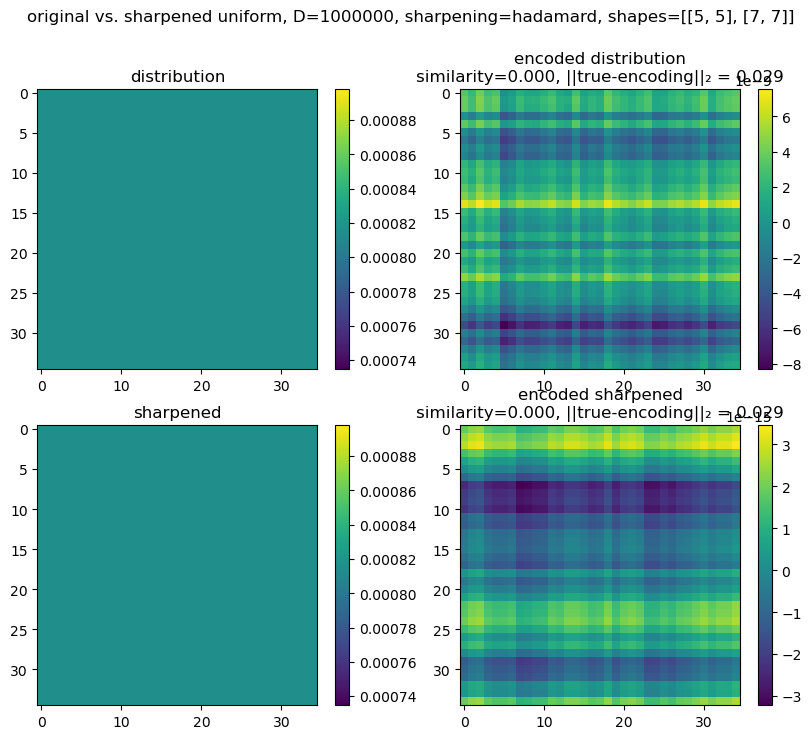

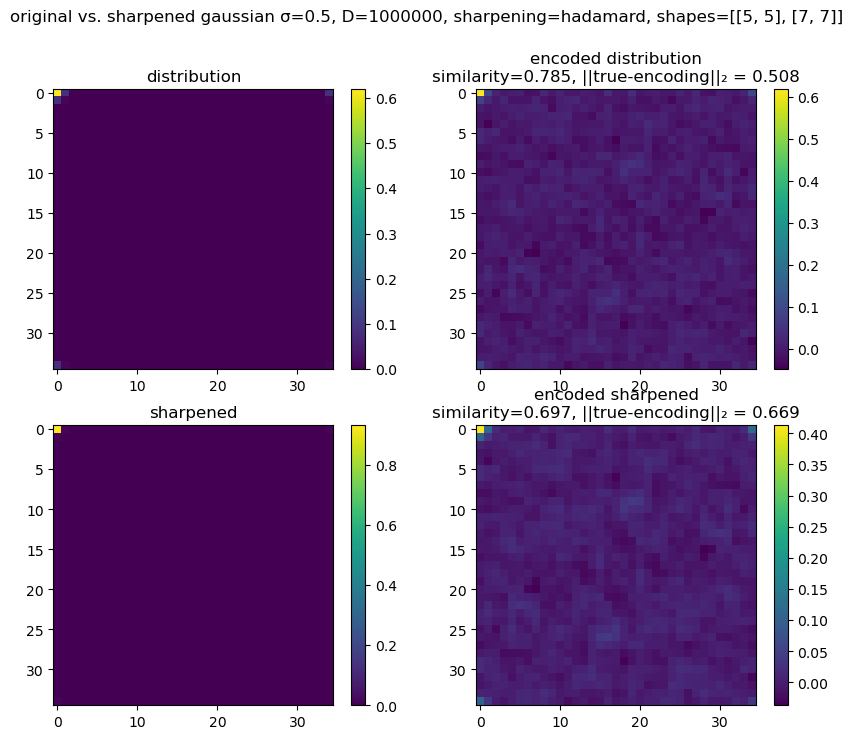

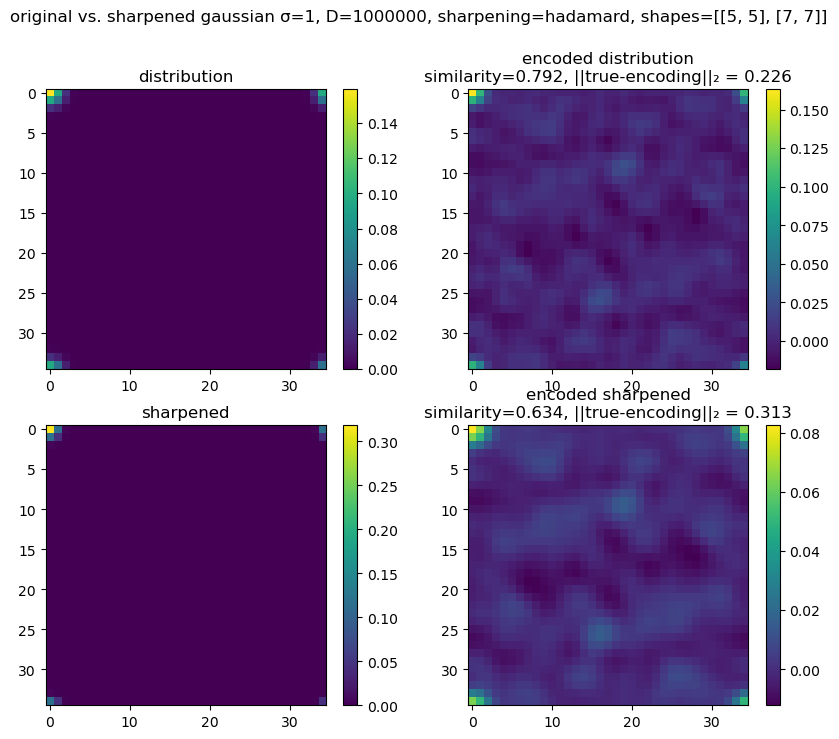

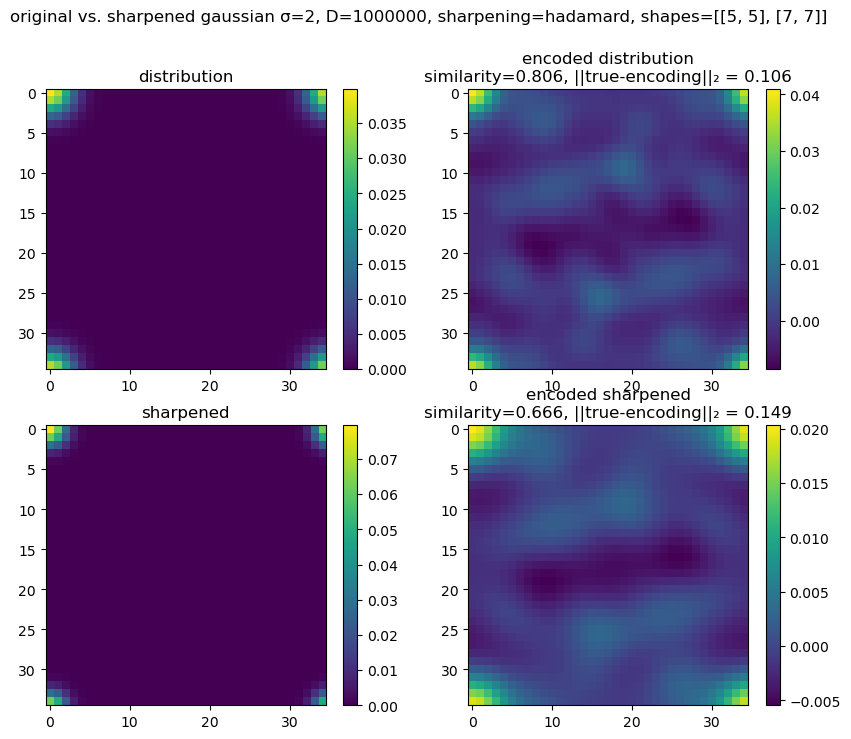

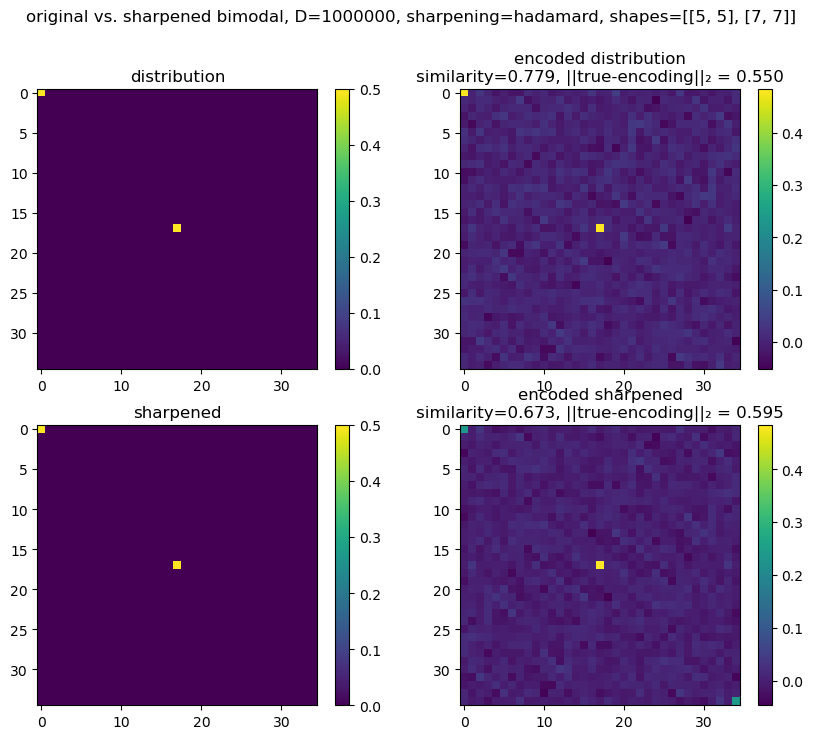

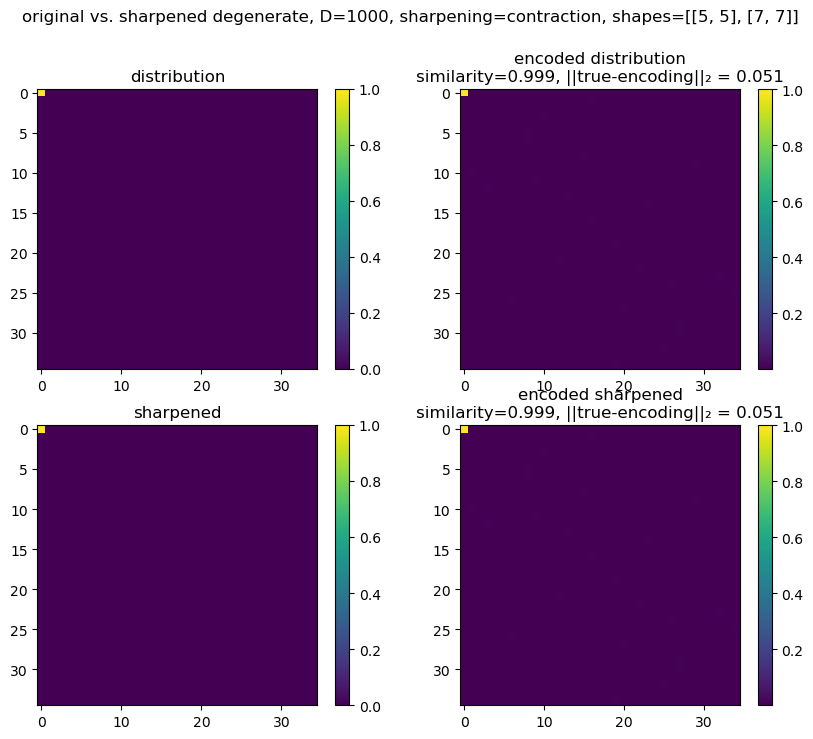

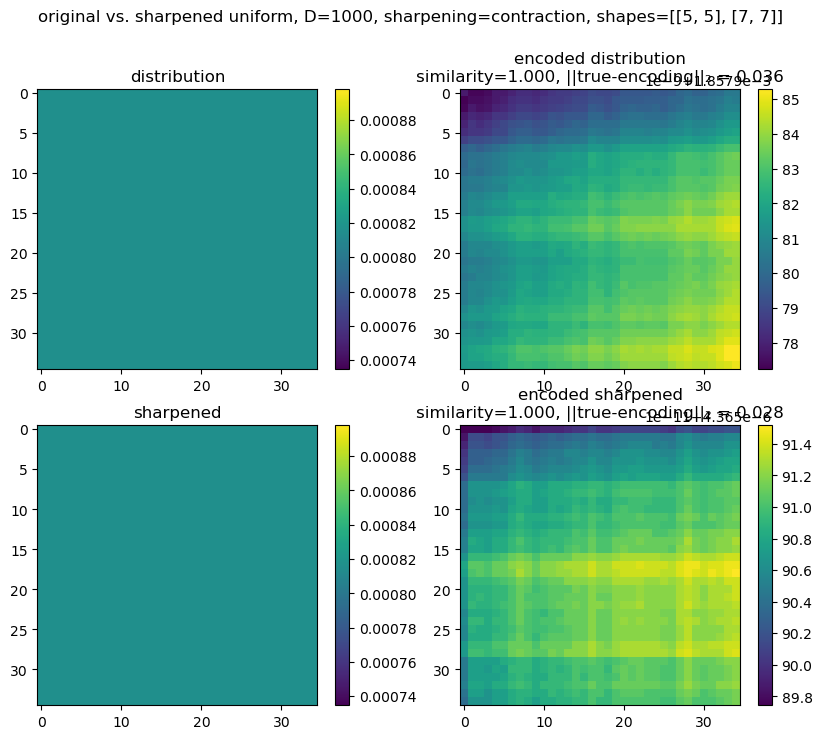

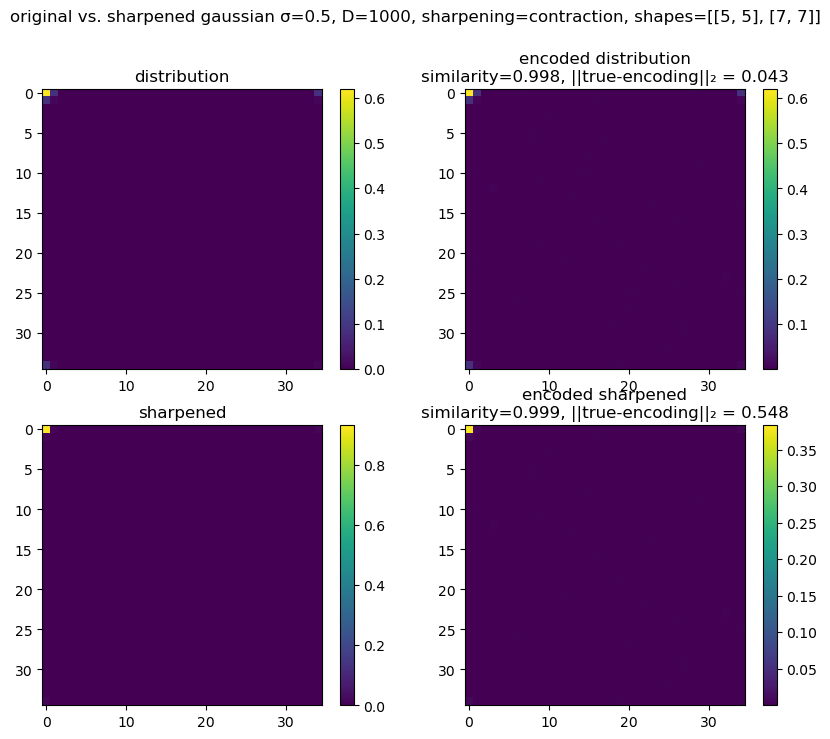

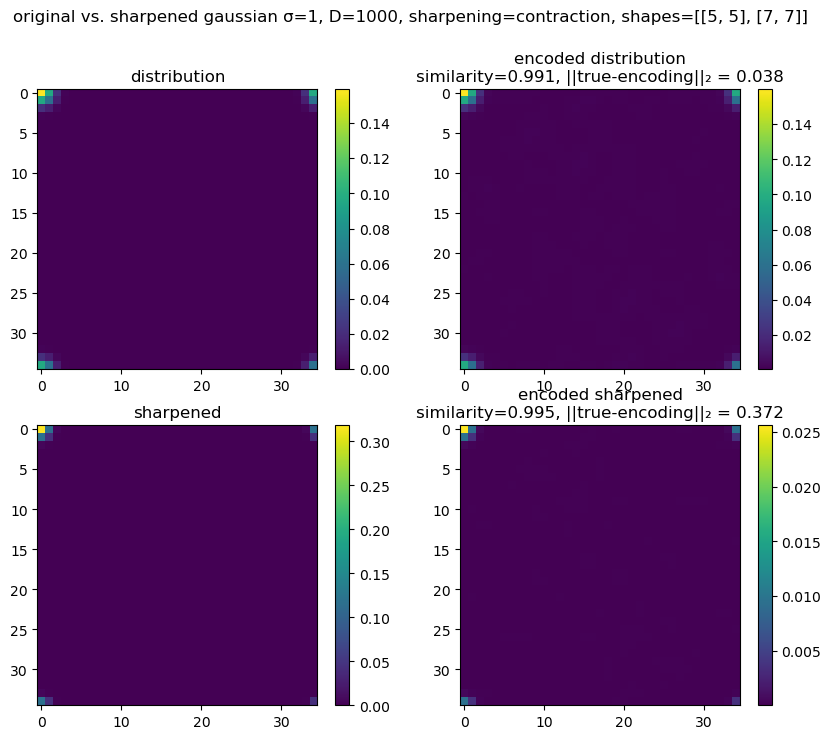

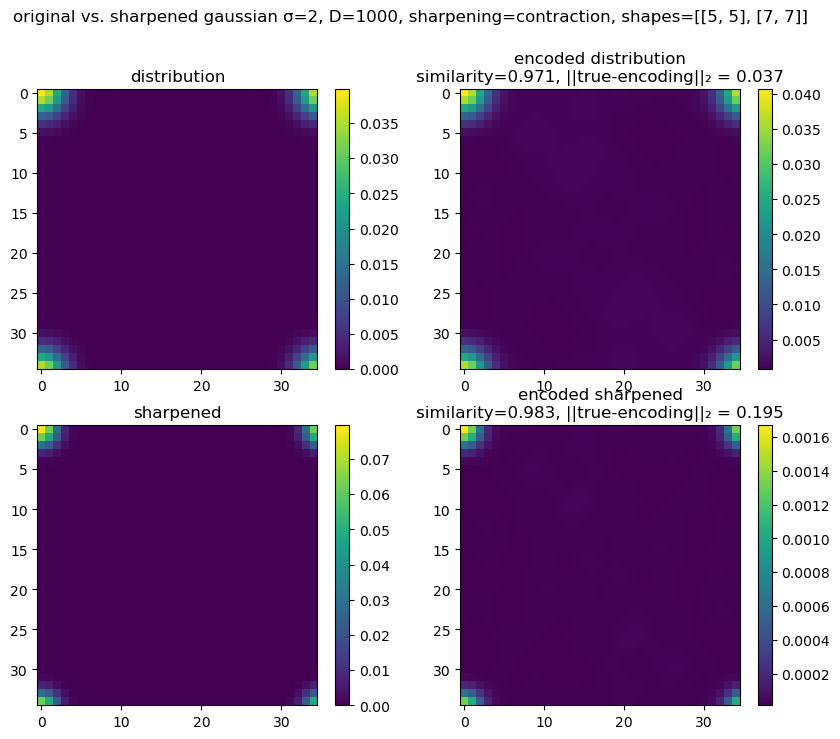

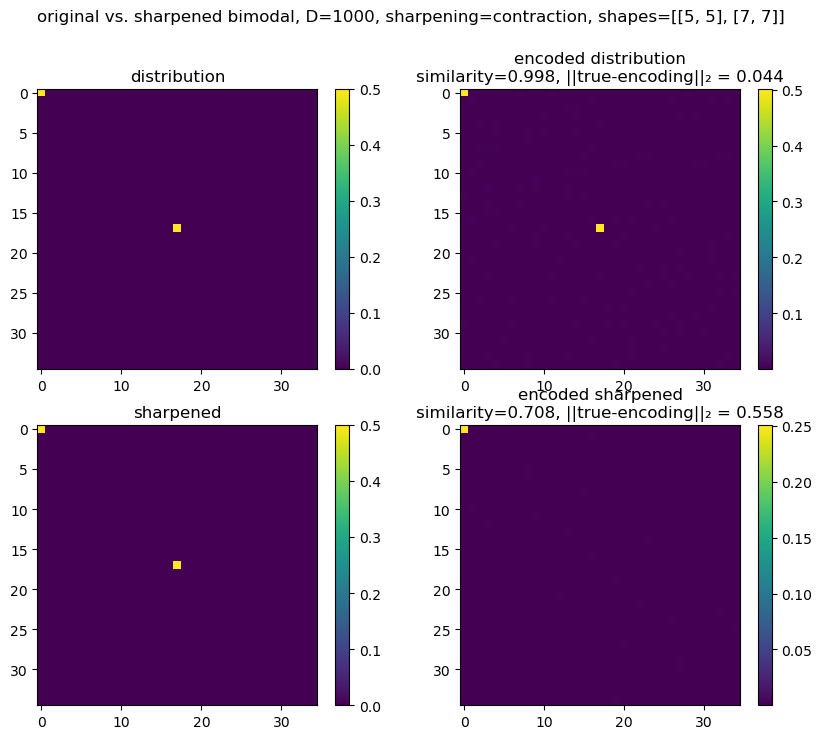

In [7]:
from graph_utils import plot_imgs_side_by_side

scaffolds = [
  FourierScaffold(
    shapes,
    D=D,
    smoothing=GaussianFourierSmoothing(
        kernel_radii=[10,10], kernel_sigmas=[1,1]
    ),  # doesnt matter just so it runs
    device=device,
    representation="vector",
    rescaling=rescaling
),
  FourierScaffold(
    shapes,
    D=D,
    sharpening=ContractionSharpening(2),
    shift=HammardShiftMatrix(),
    smoothing=GuassianFourierSmoothingMatrix(
        kernel_radii=[10,10], kernel_sigmas=[1,1]
    ),  # doesnt matter just so it runs
    device=device,
    representation="matrix",
    rescaling=rescaling
)
]
names=["hadamard", "contraction"]

for scaffold, contraction_name in zip(scaffolds, names):
    for name, distribution  in distributions:
        scaffold_debug.ptensor = distribution
        scaffold.g = scaffold.encode_probability(distribution)
        original = scaffold.get_all_probabilities().cpu().clone()

        l2_o = l2_err(original, distribution.cpu())
        sim_o = torch.cosine_similarity(original.flatten(), distribution.cpu().flatten(), dim=0)

        fig, ax = plt.subplots(2, 2, figsize=(10, 8))
        plot_imgs_side_by_side(
            [distribution.cpu(), original.cpu()],
            ax[0],
            ["distribution", f"encoded distribution\nsimilarity={sim_o:.3f}, ||true-encoding||₂ = {l2_o:.3f}"],
            fig,
            False
        )

        scaffold.sharpen()
        scaffold_debug.sharpen()

        sharpened = scaffold.get_all_probabilities().cpu().clone()

        l2_s = l2_err(sharpened, scaffold_debug.ptensor.cpu())
        sim_s = torch.cosine_similarity(sharpened.flatten(), scaffold_debug.ptensor.cpu().flatten(), dim=0)
        print(l2_o, l2_s)
        print(sharpened)
        print(sharpened-scaffold_debug.ptensor.cpu())
        plot_imgs_side_by_side(
            [scaffold_debug.ptensor.cpu(), sharpened.cpu()],
            ax[1],
            ["sharpened", f"encoded sharpened\nsimilarity={sim_s:.3f}, ||true-encoding||₂ = {l2_s:.3f}"],
            fig,
            False
        )

        fig.suptitle(f"original vs. sharpened {name}, D={D if contraction_name == 'contraction' else D**2}, sharpening={contraction_name}, shapes={shapes.tolist()}")
        if rescaling:
            fig.savefig(f"org_vs_sharp_D={D}, dist={name} sharpening={contraction_name}.png")
        else:
            fig.savefig(f"org_vs_sharp_no_rescaling_D={D}, dist={name} sharpening={contraction_name}.png")

Cross term error analysis

In [16]:
x = FourierScaffold(
    shapes,
    200,
    shift=HammardShiftMatrix(),
    smoothing=GuassianFourierSmoothingMatrix([10,10] * 1, [0.4,0.4] * 1),
    sharpening=ContractionSharpening(2),
    representation='matrix'
)

module shapes:  tensor([[5, 5],
        [7, 7]], device='cuda:0')
N_g (D) :  200
M       :  2
d       :  2
N_patts :  1225


In [41]:
omega = torch.cartesian_prod(*[torch.arange(0, dim_sizes[dim]) for dim in range(shapes.shape[1])])
if (omega.ndim == 1):
  omega = omega.unsqueeze(1)
print(omega.shape)
encodings = x.encode_batch(omega.T)

torch.Size([1225, 2])


In [42]:
print(omega.shape)
print(encodings.shape)

torch.Size([1225, 2])
torch.Size([200, 200, 1225])


In [43]:
encodings = encodings.flatten(0,1)
print(encodings.shape)

torch.Size([40000, 1225])


In [44]:
results = (encodings.T @ encodings.conj()) ** 0.5
print(results)

tensor([[1.0000+0.0000e+00j, 0.0789-1.3886e-08j, 0.0179-4.2144e-08j,
          ..., 0.0399+1.0212e-08j, 0.1018-7.6103e-09j,
         0.0276-5.0635e-09j],
        [0.0789+1.3886e-08j, 1.0000+0.0000e+00j, 0.0789+5.6284e-09j,
          ..., 0.1597-5.9900e-09j, 0.0399-2.7353e-09j,
         0.1018-1.4292e-09j],
        [0.0179+4.2144e-08j, 0.0789-5.6284e-09j, 1.0000+0.0000e+00j,
          ..., 0.0706+5.9733e-09j, 0.1597-2.8925e-09j,
         0.0399+4.3765e-09j],
        ...,
        [0.0399-1.0212e-08j, 0.1597+5.9900e-09j, 0.0706-5.9733e-09j,
          ..., 1.0000+0.0000e+00j, 0.0789+1.7531e-09j,
         0.0179+2.0260e-08j],
        [0.1018+7.6103e-09j, 0.0399+2.7353e-09j, 0.1597+2.8925e-09j,
          ..., 0.0789-1.7531e-09j, 1.0000+0.0000e+00j,
         0.0789+5.3977e-09j],
        [0.0276+5.0635e-09j, 0.1018+1.4292e-09j, 0.0399-4.3765e-09j,
          ..., 0.0179-2.0260e-08j, 0.0789-5.3977e-09j,
         1.0000+0.0000e+00j]])


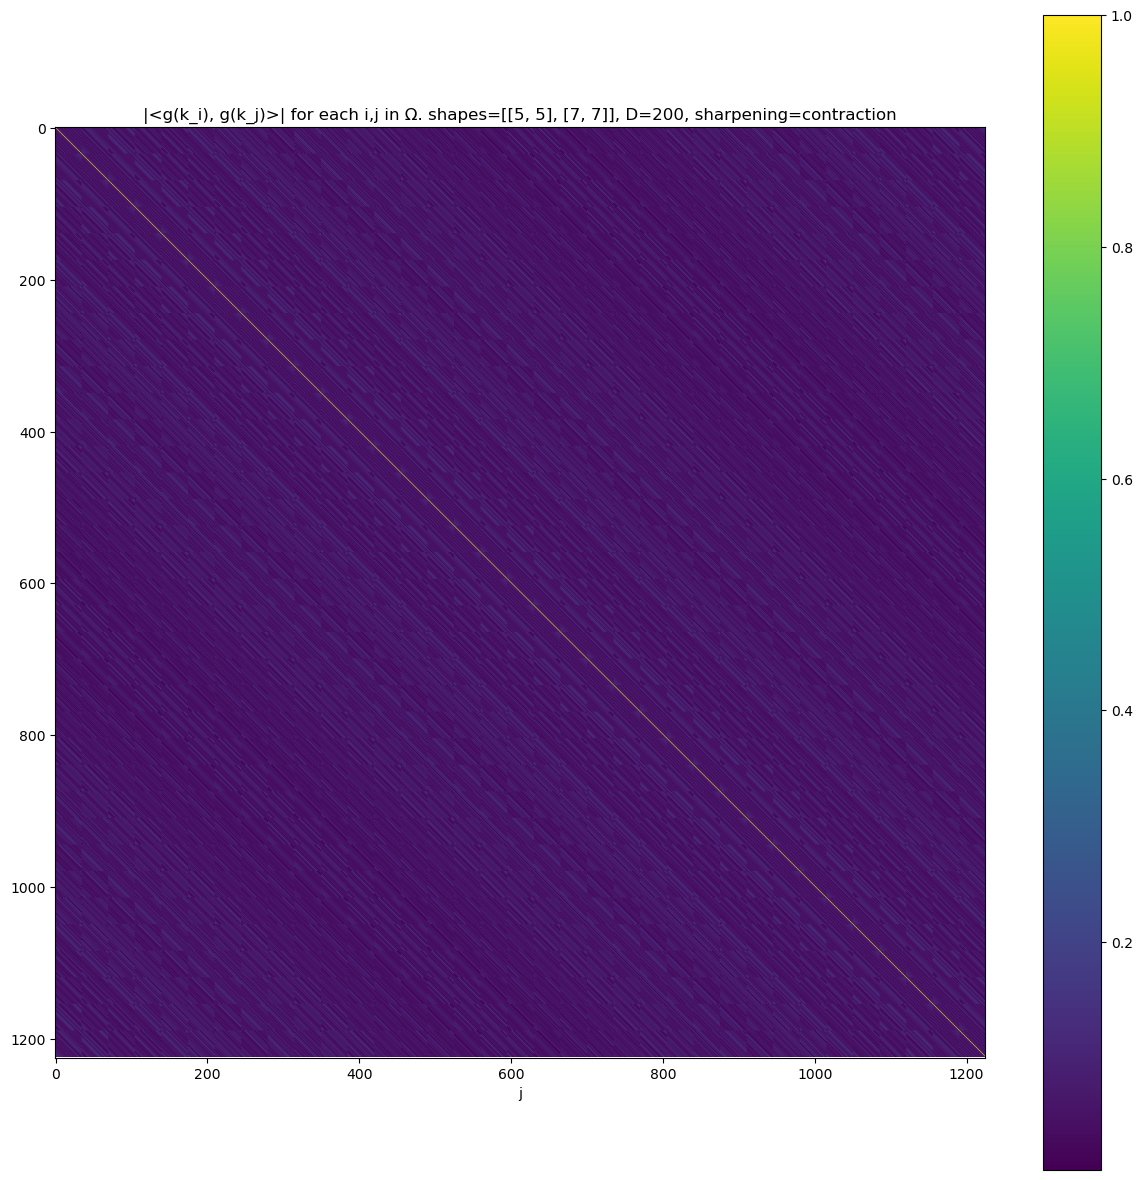

In [45]:
fig, ax =plt.subplots(figsize=(15,15))
im = ax.imshow(results.abs())
ax.set_xlabel('i')
ax.set_xlabel('j')
ax.set_title(f'|<g(k_i), g(k_j)>| for each i,j in Ω. shapes={shapes.tolist()}, D=200, sharpening=contraction')
fig.colorbar(im, ax=ax)

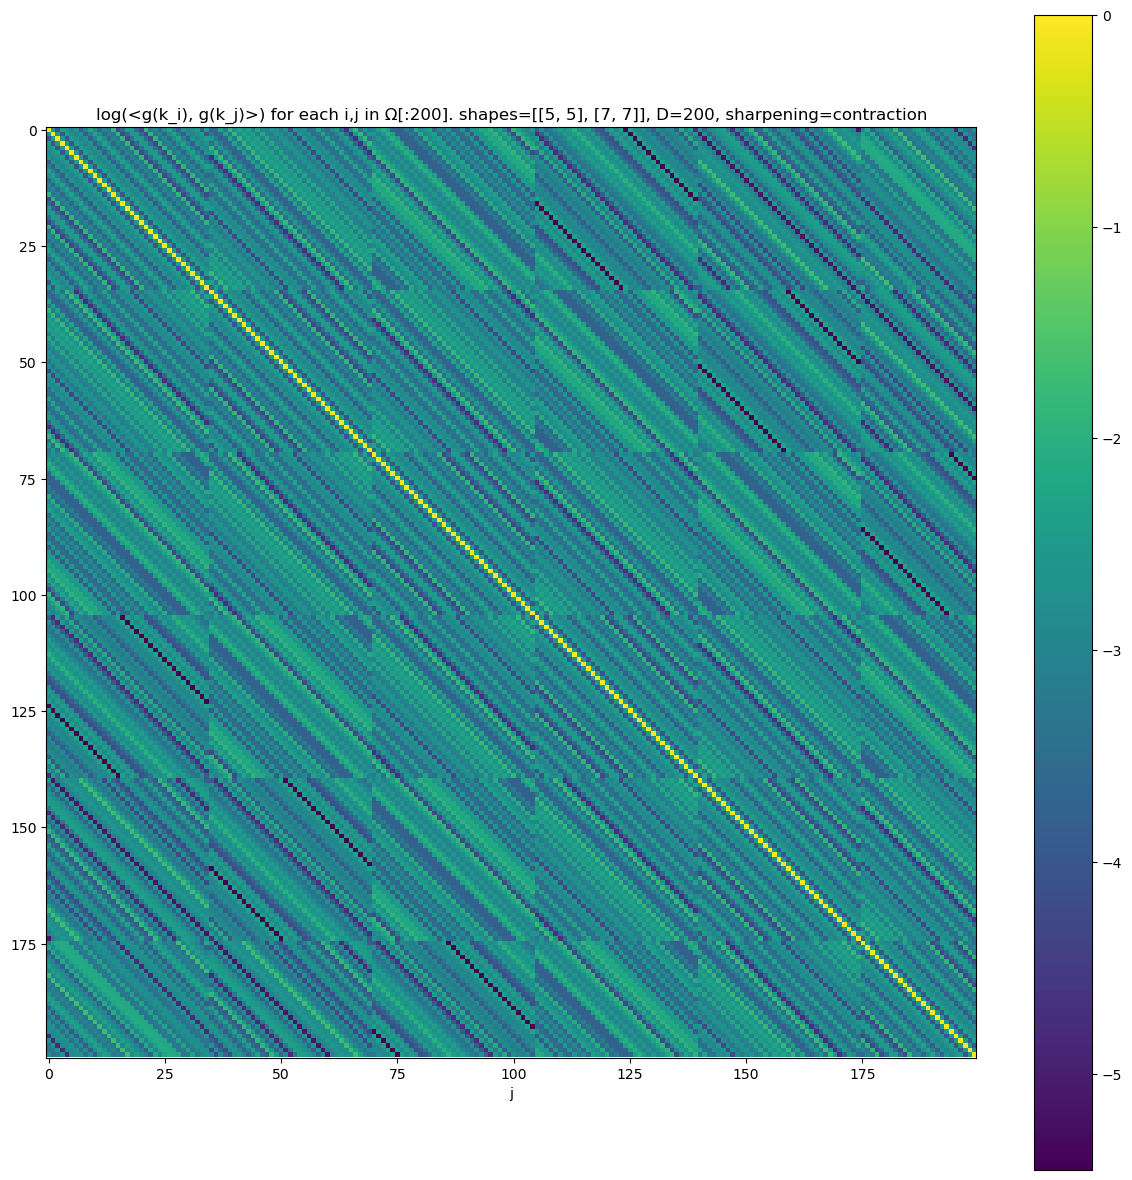

In [46]:
fig, ax =plt.subplots(figsize=(15,15))
ax.set_xlabel('i')
ax.set_xlabel('j')
ax.set_title(f'log(<g(k_i), g(k_j)>) for each i,j in Ω[:200]. shapes={shapes.tolist()}, D=200, sharpening=contraction')
im = ax.imshow(results[:200, :200].abs().log())
fig.colorbar(im, ax=ax)

In [47]:
error = results - torch.diag(torch.ones(len(omega)))

In [48]:
print(error)

tensor([[ 1.4305e-06+0.0000e+00j,  7.8856e-02-1.3886e-08j,
          1.7934e-02-4.2144e-08j,  ...,
          3.9900e-02+1.0212e-08j,  1.0182e-01-7.6103e-09j,
          2.7571e-02-5.0635e-09j],
        [ 7.8856e-02+1.3886e-08j, -5.3644e-07+0.0000e+00j,
          7.8856e-02+5.6284e-09j,  ...,
          1.5973e-01-5.9900e-09j,  3.9900e-02-2.7353e-09j,
          1.0182e-01-1.4292e-09j],
        [ 1.7934e-02+4.2144e-08j,  7.8856e-02-5.6284e-09j,
         -2.9802e-07+0.0000e+00j,  ...,
          7.0649e-02+5.9733e-09j,  1.5973e-01-2.8925e-09j,
          3.9900e-02+4.3765e-09j],
        ...,
        [ 3.9900e-02-1.0212e-08j,  1.5973e-01+5.9900e-09j,
          7.0649e-02-5.9733e-09j,  ...,
          3.4571e-06+0.0000e+00j,  7.8856e-02+1.7531e-09j,
          1.7934e-02+2.0260e-08j],
        [ 1.0182e-01+7.6103e-09j,  3.9900e-02+2.7353e-09j,
          1.5973e-01+2.8925e-09j,  ...,
          7.8856e-02-1.7531e-09j,  3.5763e-06+0.0000e+00j,
          7.8856e-02+5.3977e-09j],
        [ 2.7571e-02+5

In [49]:
print(error.abs().max())
print(error.abs().min())
print(error.abs().mean())
print(error.abs().std())
print(error.abs().sum())
print(len(error.flatten()))

tensor(0.1817)
tensor(0.)
tensor(0.0609)
tensor(0.0343)
tensor(91393.4531)
1500625


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([131075., 267050., 313600., 308700., 210700., 129850.,  68600.,
         36750.,  22050.,  12250.]),
 array([-5.96046448e-07,  1.81730594e-02,  3.63467149e-02,  5.45203723e-02,
         7.26940259e-02,  9.08676833e-02,  1.09041341e-01,  1.27214998e-01,
         1.45388648e-01,  1.63562313e-01,  1.81735963e-01]),
 <BarContainer object of 10 artists>)

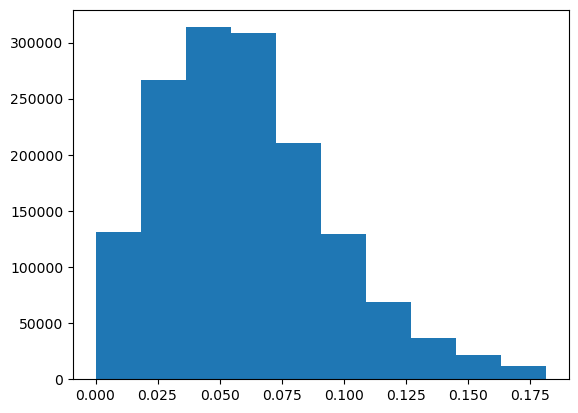

In [50]:
plt.hist(error.flatten())

(array([1.6000e+01, 2.3000e+01, 1.2500e+02, 6.3200e+02, 4.0200e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4500e+03, 1.4700e+04,
        2.4500e+04, 8.8200e+04, 1.6660e+05, 3.3075e+05, 5.2430e+05,
        3.0135e+05, 4.6550e+04, 0.0000e+00, 0.0000e+00]),
 array([-15. , -14.5, -14. , -13.5, -13. , -12.5, -12. , -11.5, -11. ,
        -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,  -6.5,
         -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,  -2. ,
         -1.5,  -1. ,  -0.5]),
 <BarContainer object of 29 artists>)

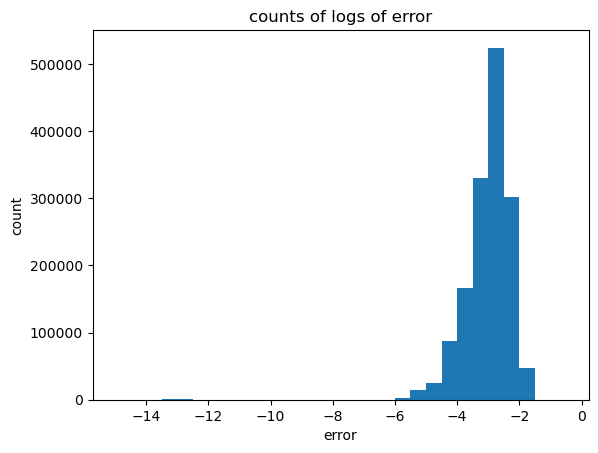

In [52]:
bins = torch.arange(-15, 0, 0.5)
plt.ylabel('count')
plt.xlabel('error')
plt.title('counts of logs of error')
plt.hist((error.abs()+1e-8).log().flatten(), bins=bins)

In [54]:
off_diag_error = results
off_diag_error.fill_diagonal_(0)
print(off_diag_error)


tensor([[0.0000+0.0000e+00j, 0.0789-1.3886e-08j, 0.0179-4.2144e-08j,
          ..., 0.0399+1.0212e-08j, 0.1018-7.6103e-09j,
         0.0276-5.0635e-09j],
        [0.0789+1.3886e-08j, 0.0000+0.0000e+00j, 0.0789+5.6284e-09j,
          ..., 0.1597-5.9900e-09j, 0.0399-2.7353e-09j,
         0.1018-1.4292e-09j],
        [0.0179+4.2144e-08j, 0.0789-5.6284e-09j, 0.0000+0.0000e+00j,
          ..., 0.0706+5.9733e-09j, 0.1597-2.8925e-09j,
         0.0399+4.3765e-09j],
        ...,
        [0.0399-1.0212e-08j, 0.1597+5.9900e-09j, 0.0706-5.9733e-09j,
          ..., 0.0000+0.0000e+00j, 0.0789+1.7531e-09j,
         0.0179+2.0260e-08j],
        [0.1018+7.6103e-09j, 0.0399+2.7353e-09j, 0.1597+2.8925e-09j,
          ..., 0.0789-1.7531e-09j, 0.0000+0.0000e+00j,
         0.0789+5.3977e-09j],
        [0.0276+5.0635e-09j, 0.1018+1.4292e-09j, 0.0399-4.3765e-09j,
          ..., 0.0179-2.0260e-08j, 0.0789-5.3977e-09j,
         0.0000+0.0000e+00j]])
